In [2]:
# Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ccpi.framework import ImageData, ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer

from ccpi.optimisation.functions import L2NormSquared, ZeroFunction, BlockFunction, MixedL21Norm, IndicatorBox, FunctionOperatorComposition
from ccpi.optimisation.operators import Gradient, BlockOperator
from ccpi.optimisation.algorithms import PDHG, SIRT, CGLS

from ccpi.astra.operators import AstraProjectorSimple, AstraProjector3DSimple
from ccpi.astra.processors import FBP

from ccpi.processors import Resizer, CenterOfRotationFinder

from ccpi.io import NEXUSDataReader

import tomophantom
from tomophantom import TomoP2D, TomoP3D
import os, sys

import matplotlib.pyplot as plt

import numpy as np

from utilities import islicer, link_islicer
from utilities.show_utilities import show

%matplotlib inline

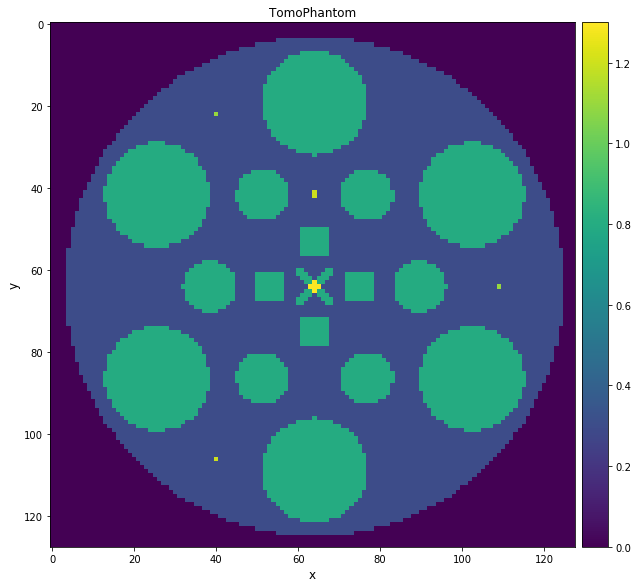

In [19]:
model = 11 # select a model number from the library
N = 128 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom = TomoP2D.Model(model, N, path_library2D) 

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N)
im_data = ig.allocate()
im_data.fill(phantom)

show(im_data, title = 'TomoPhantom',  figure_size = (10,10))

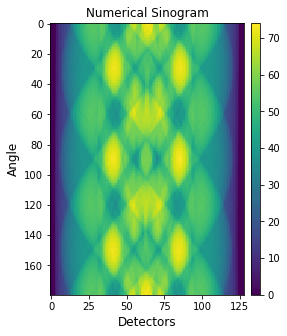

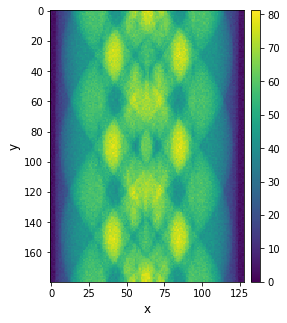

In [43]:
# Create AcquisitionGeometry and AcquisitionData 
detectors = N
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry('parallel','2D', angles, detectors)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = AstraProjectorSimple(ig, ag, device = 'gpu')

# Create an acqusition data (numerically)
sino_num = A.direct(im_data)

# Show numerical sinogram
show(sino_num, title = 'Numerical Sinogram', labels = ['Detectors','Angle'])

def noise(sinogram, sigma, seed):

    tmp_sinp = sinogram.as_array()
    maxSino = np.max(tmp_sinp)
    if maxSino > 0:
        sino_noisy = tmp_sinp/maxSino
        dataExp = sigma*np.exp(-sino_noisy)  # noiseless raw data
        sino_noisy = np.random.poisson(dataExp) #adding Poisson noise
        div_res = np.float32(sino_noisy)/np.max(sino_noisy)
        sino_noisy = -np.log(div_res)*maxSino # log corrected data -> sinogram
        sino_noisy[sino_noisy<0] = 0
        
    return AcquisitionData(sino_noisy, geometry = sinogram.geometry)

sino_noisy = noise(sino_num,5e3,5)

show(sino_noisy)

PDHG setting up
PDHG configured


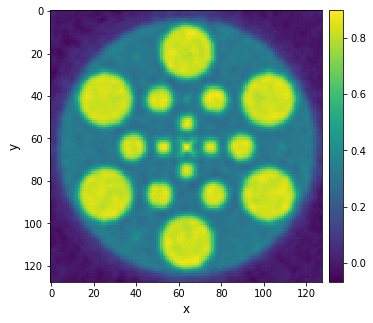

In [30]:
alpha = 30
Grad = Gradient(ig)
K = BlockOperator(A, Grad)

f1 = L2NormSquared(sino_noisy)
f2 = alpha**2 * L2NormSquared()
F = BlockFunction(f1, f2)

G = ZeroFunction()

normK = K.norm()
sigma = 1
tau = 1/(sigma*normK**2)
pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iteration = 1000,
           update_objective_interval = 100)
pdhg.run(verbose=False)

tikhonov = pdhg.get_output()

show(tikhonov)

PDHG setting up
PDHG configured


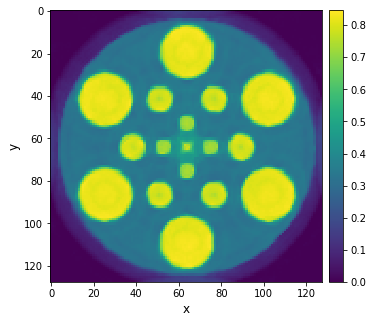

In [42]:
alpha = 100
Grad = Gradient(ig)
K = BlockOperator(A, Grad)

f1 = 0.5 * L2NormSquared(sino_noisy)
f2 = alpha * MixedL21Norm()
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=0)

sigma = 10
tau = 1/(sigma*normK**2)
pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
                        max_iteration = 1000,
           update_objective_interval = 100)
pdhg.run(verbose=False)

tv = pdhg.get_output()

show(tv)

SIRT setting up
SIRT configured
CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          5.83792e+07
       50        100         0.006          1.64245e+06
      100        100         0.005          2.02065e+04


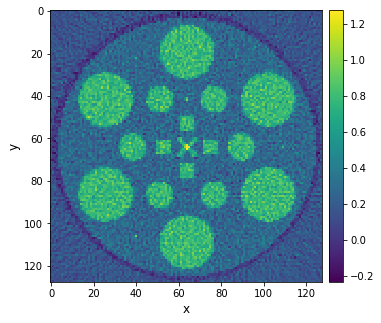

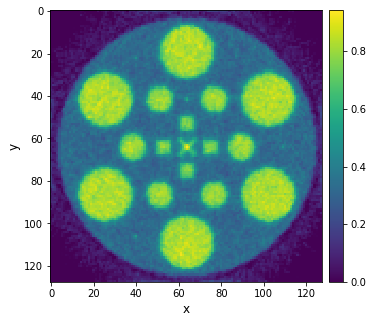

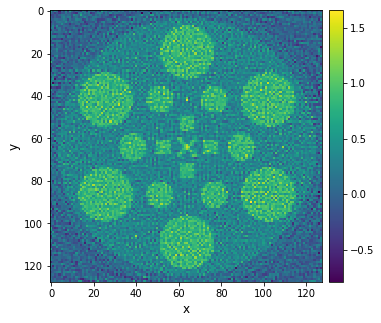

In [38]:
# FBP reconstruction
fbp = FBP(ig, ag, filter_type = 'ram-lak')
fbp.set_input(sino_noisy)
fbp_recon = fbp.get_output()
show(fbp_recon)


# Run SIRT algoritm, with positivity constraint

# Setup and run the SIRT algorithm  
x_init = ig.allocate()  

sirt = SIRT(x_init = x_init, operator = A, data=sino_noisy, constraint = IndicatorBox(lower=0),
           max_iteration = 50)
sirt.run(verbose=False)

sirt_recon = sirt.get_output()
show(sirt_recon)

x_init = ig.allocate()
cgls = CGLS(x_init = x_init, operator = A, data = sino_noisy, 
            max_iteration = 100, update_objective_interval = 50)
cgls.run(verbose = True)
cgls_recon = cgls.get_output()
show(cgls_recon)